In [1]:
import reservoirpy as rpy
import reservoirpy.nodes as rpn
from reservoirpy.datasets import lorenz, rossler, doublescroll, kuramoto_sivashinsky

import numpy as np
from matplotlib import pyplot as plt

rpy.verbosity(False)

rpy.set_seed(42)

name_idx = 0

In [2]:
def add_noise(time_series, noise_type="random", noise_level=0.5):
    """
    对输入的时间序列添加噪声。
    
    参数:
        time_series (numpy.ndarray): 输入的时间序列。
        noise_type (str): 噪声类型，可选值为 "random"（随机噪声）, "sin"（正弦噪声）, 或 "gaussian"（正态分布噪声）。
        noise_level (float): 噪声强度，决定噪声幅度。
    
    返回:
        numpy.ndarray: 添加噪声后的时间序列。
    """
    if noise_type == "random":
        noise = np.random.uniform(-noise_level, noise_level, len(time_series))
    elif noise_type == "sin":
        noise = noise_level * np.sin(30 * np.pi * np.arange(len(time_series)) / len(time_series))
    elif noise_type == "gaussian":
        noise = np.random.normal(0, noise_level, len(time_series))
    else:
        raise ValueError("Unsupported noise_type. Choose from 'random', 'sin', or 'gaussian'.")
    
    return time_series + np.stack((noise,noise,noise)).T

In [3]:
def show(t1, t2, figsize=(18, 6), title="Lorenz Attractor"):
    '''
    t1: Noisy data(plot with solid line & orange color)
    
    t2: Clean data(plot with dashed line & blue color)
    '''
    plt.figure(figsize=figsize)

    plt.subplot(3, 1, 1)
    #plt.plot(t2[:,0])
    plt.plot(t1[:,0], color='#ff7f0e')
    plt.plot(t2[:,0], linestyle='--')
    plt.title('X-component')

    plt.subplot(3, 1, 2)
    #plt.plot(t2[:,1])
    plt.plot(t1[:,1], color='#ff7f0e')
    plt.plot(t2[:,1], linestyle='--')
    plt.title('Y-component')

    plt.subplot(3, 1, 3)
    #plt.plot(t2[:,2])
    plt.plot(t1[:,2], color='#ff7f0e')
    plt.plot(t2[:,2], linestyle='--')
    plt.title('Z-component')
    
    fig = plt.figure(figsize=(12,5), dpi=150)
    
    rmse = np.sqrt(np.mean((t1 - t2)**2))
    fig.suptitle(f"{title}\nRMSE: {rmse:.8f}")
    
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(t2[:,0], t2[:,1], t2[:,2])
    ax.set_title("Raw Data")

    ax = fig.add_subplot(122, projection='3d')
    ax.plot(t1[:,0], t1[:,1], t1[:,2], color='#ff7f0e')
    ax.set_title("Processed Data")
    
    plt.show()

### Data acquisition

In [4]:
norm01 = lambda x: (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

lorenz_data = norm01(lorenz(12000, h=0.01)[2000:,:])
rossler_data = norm01(rossler(12000, h=0.02)[2000:,:])
doublescroll_data = norm01(doublescroll(12000, h=0.1)[2000:,:])

noisy_lorenz_data = add_noise(lorenz_data, noise_type="gaussian", noise_level=0.8)
noisy_rossler_data = add_noise(rossler_data, noise_type="gaussian", noise_level=0.8)
noisy_doublescroll_data = add_noise(doublescroll_data, noise_type="gaussian", noise_level=0.8)

d:\python\lib\site-packages\reservoirpy\datasets\_chaos.py:437: RuntimeWarning: overflow encountered in sinh
  factor = (dV / r2) + ir * np.sinh(beta * dV)
d:\python\lib\site-packages\reservoirpy\datasets\_chaos.py:438: RuntimeWarning: invalid value encountered in scalar subtract
  dV1 = (V1 / r1) - factor
d:\python\lib\site-packages\scipy\integrate\_ivp\rk.py:109: RuntimeWarning: invalid value encountered in divide
  return norm(self._estimate_error(K, h) / scale)


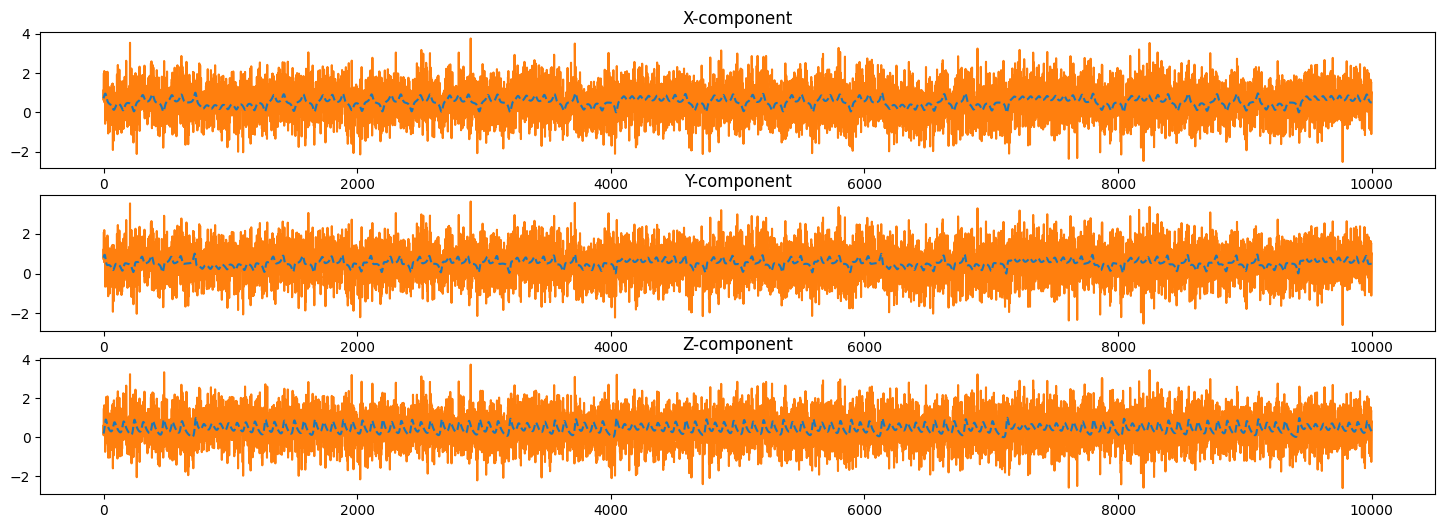

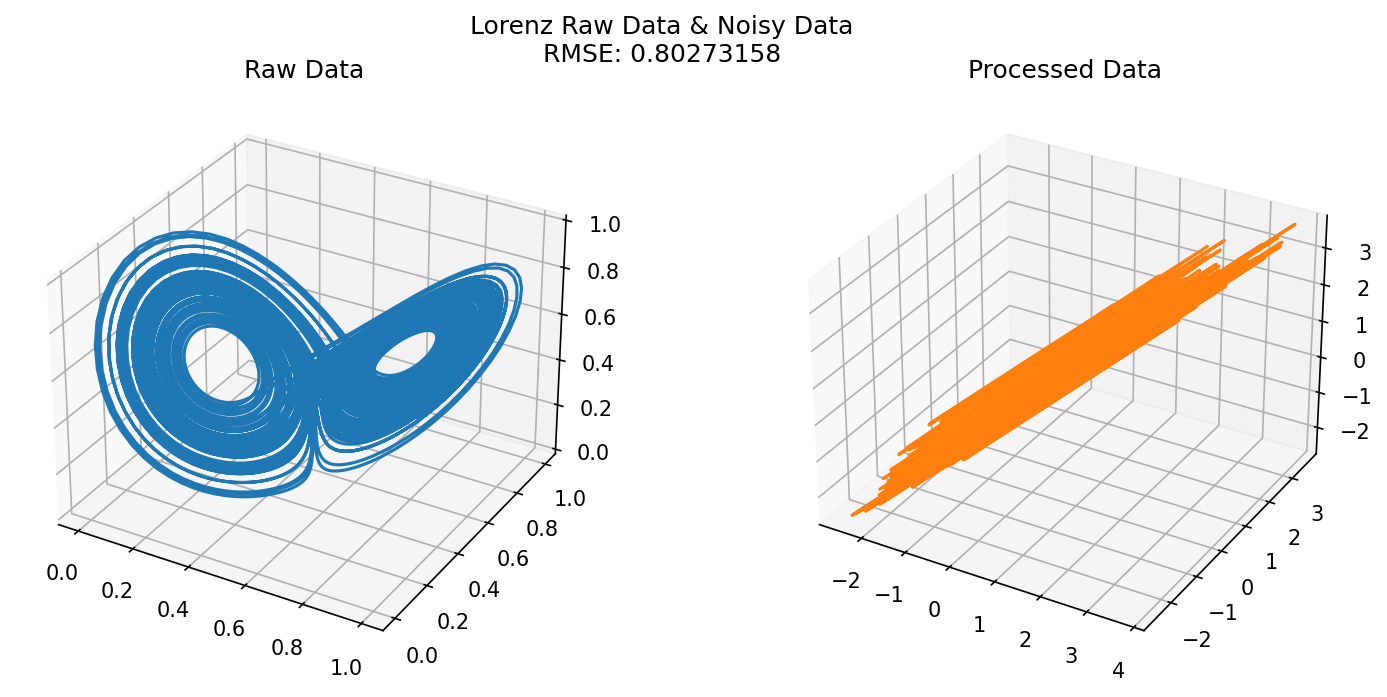

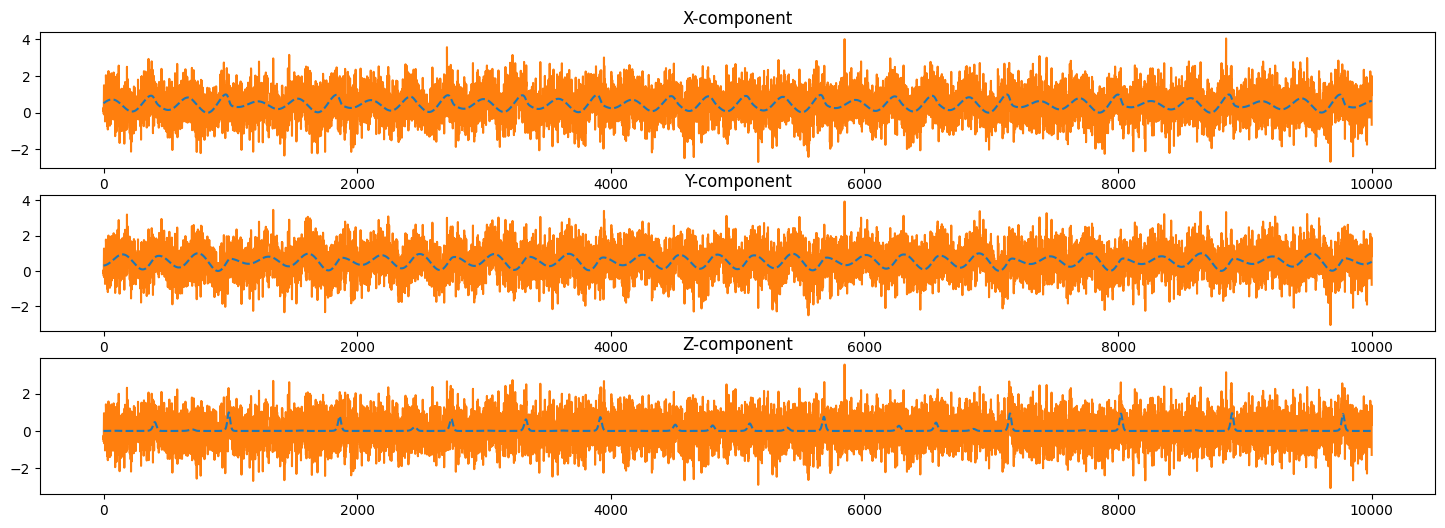

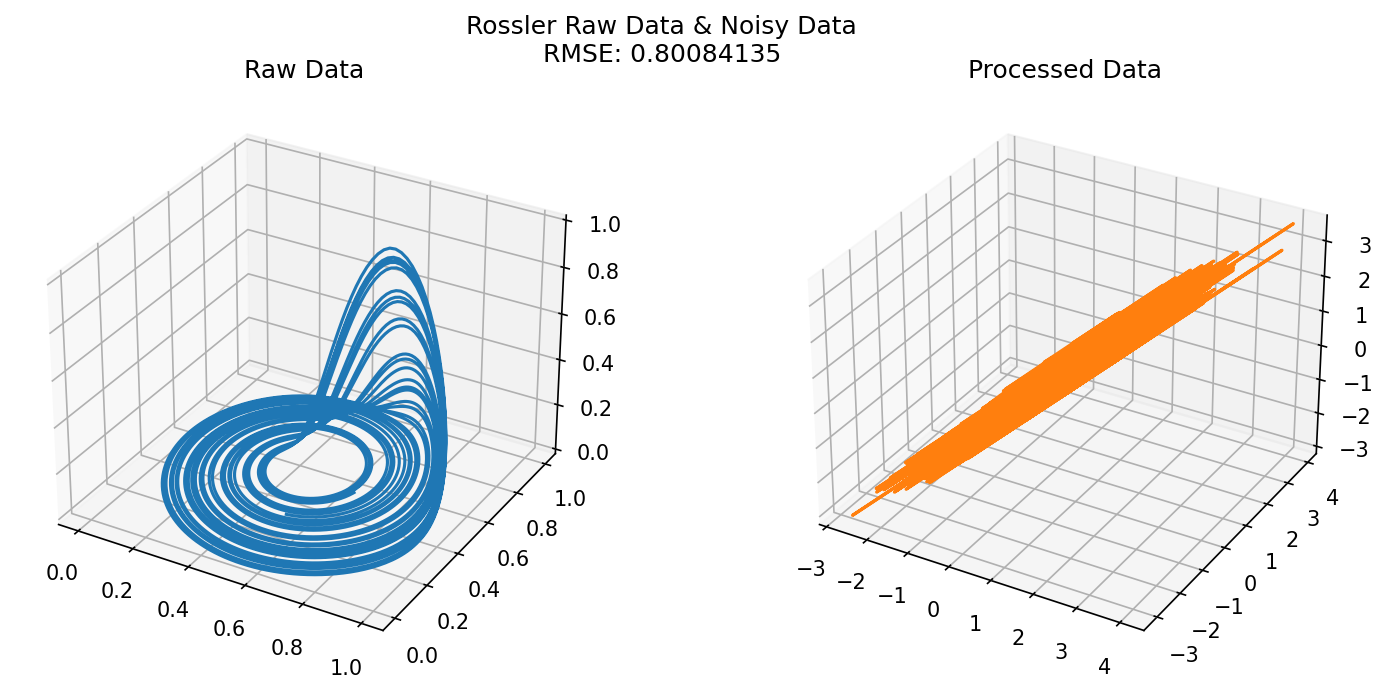

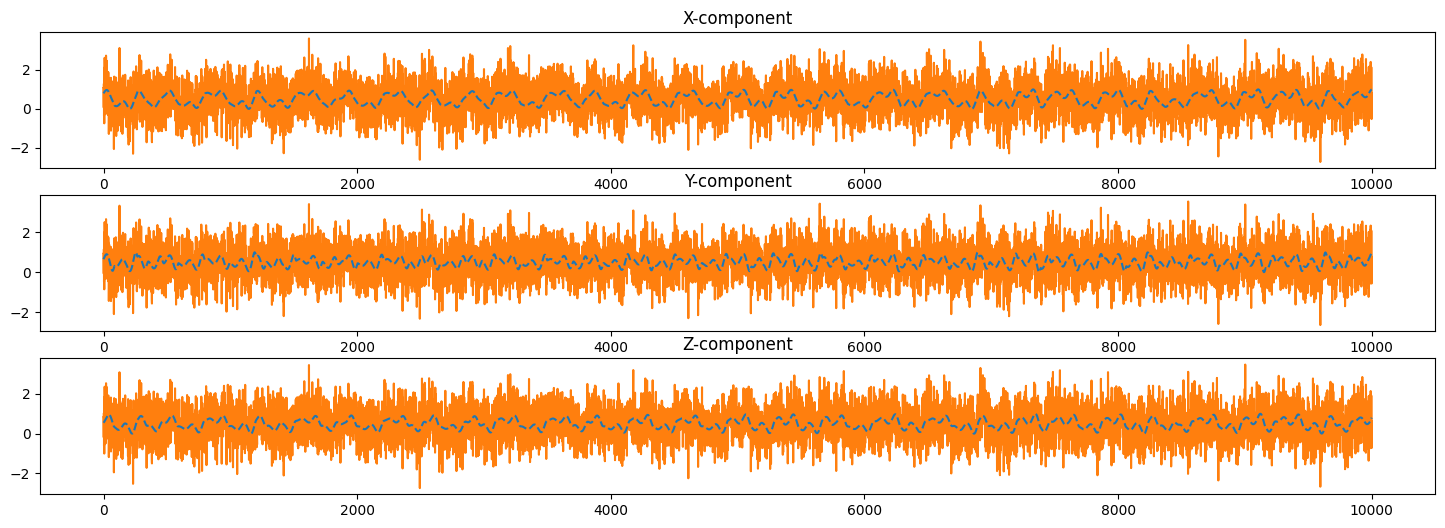

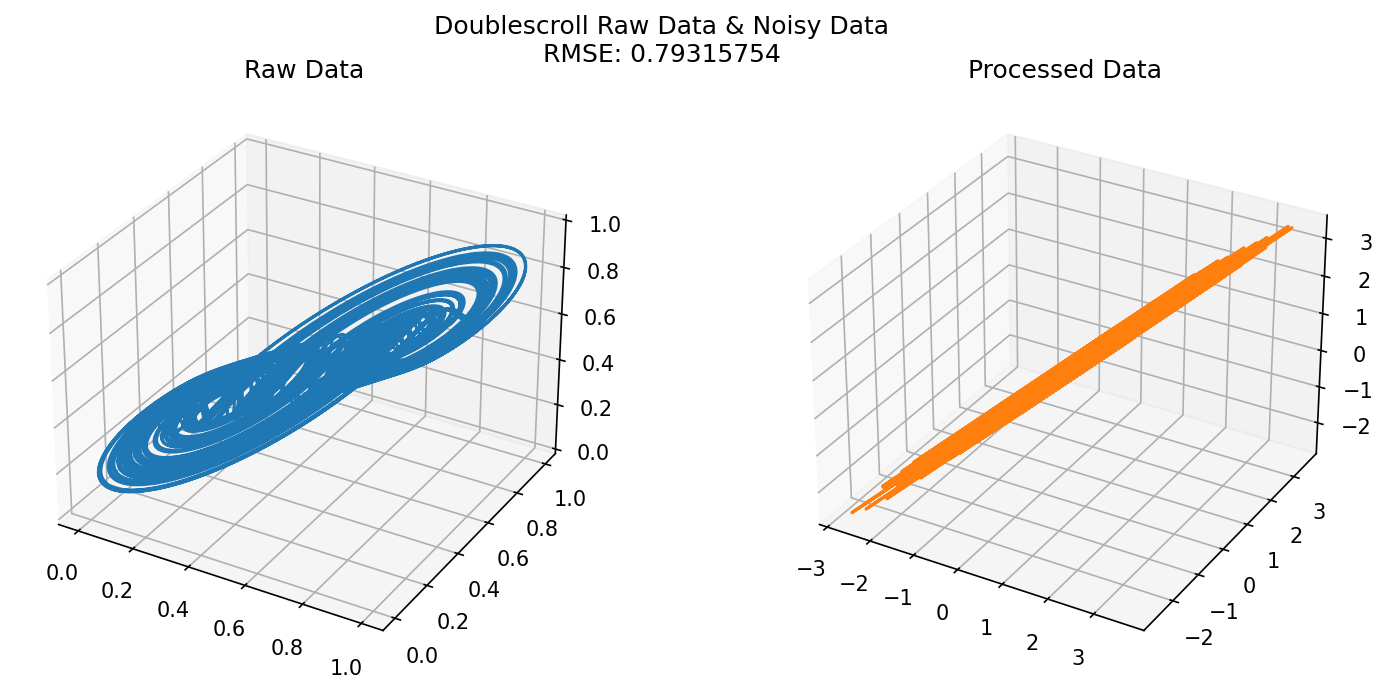

In [5]:
show(noisy_lorenz_data, lorenz_data, title="Lorenz Raw Data & Noisy Data")
show(noisy_rossler_data, rossler_data, title="Rossler Raw Data & Noisy Data")
show(noisy_doublescroll_data, doublescroll_data, title="Doublescroll Raw Data & Noisy Data")

### Lorenz Test Case

In [6]:
lorenz_train_input = noisy_lorenz_data[:7000]
lorenz_train_target = lorenz_data[:7000]

In [7]:
lorenz_res = rpn.Reservoir(units=1000, lr=0.5, sr=0.9, activation='tanh', equation='external')
lorenz_readout = rpn.Ridge(ridge=5e-3)

In [8]:
# train readout
states = lorenz_res.run(lorenz_train_input)
lorenz_readout.fit(states, lorenz_train_target)
output = lorenz_readout.run(states)

### Show the Training

RMSE of output: 0.056250794526322166


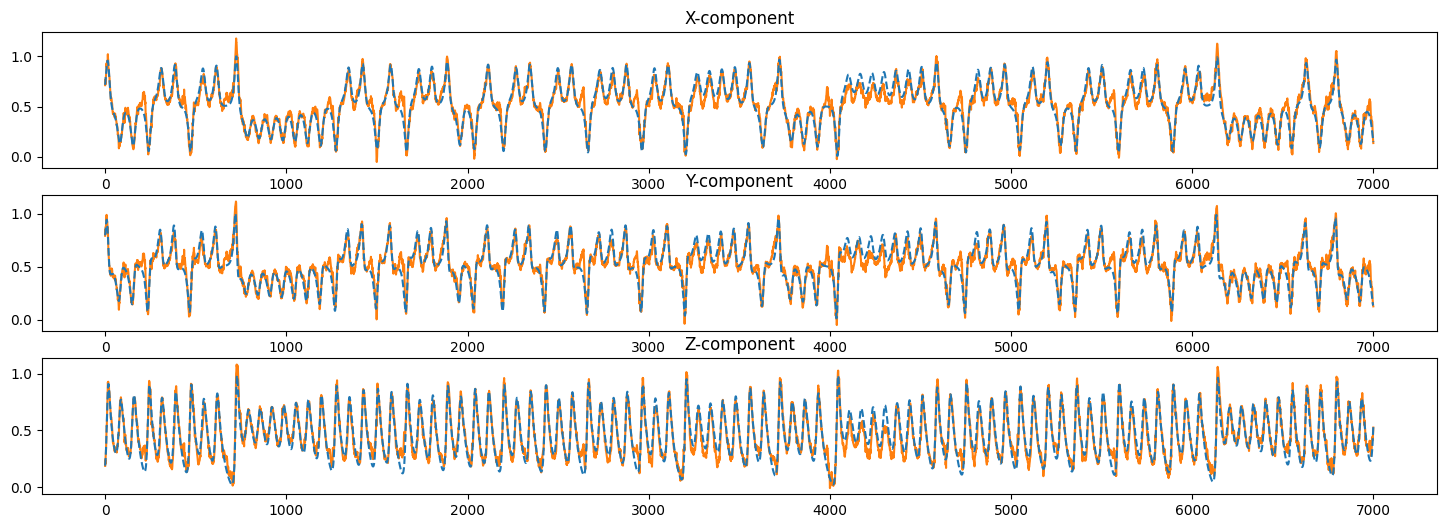

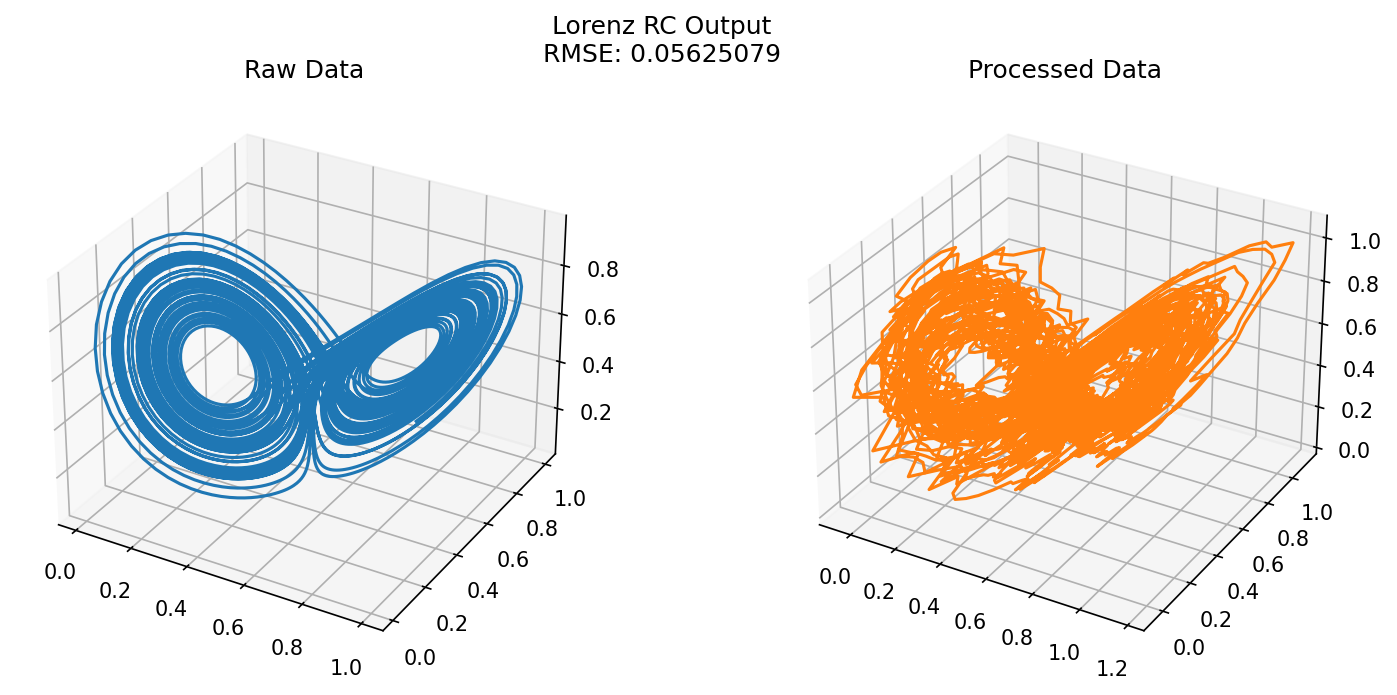

In [9]:
print(f'RMSE of output: {np.sqrt(np.mean((output - lorenz_train_target)**2))}')
show(output, lorenz_train_target, title="Lorenz RC Output")

In [10]:
lorenz_test_input = noisy_lorenz_data[7000:]
lorenz_test_target = lorenz_data[7000:]

In [11]:
# test
states = lorenz_res.run(lorenz_test_input)
output = lorenz_readout.run(states)

### Show the Prediction

RMSE of output: 0.08641080181868445


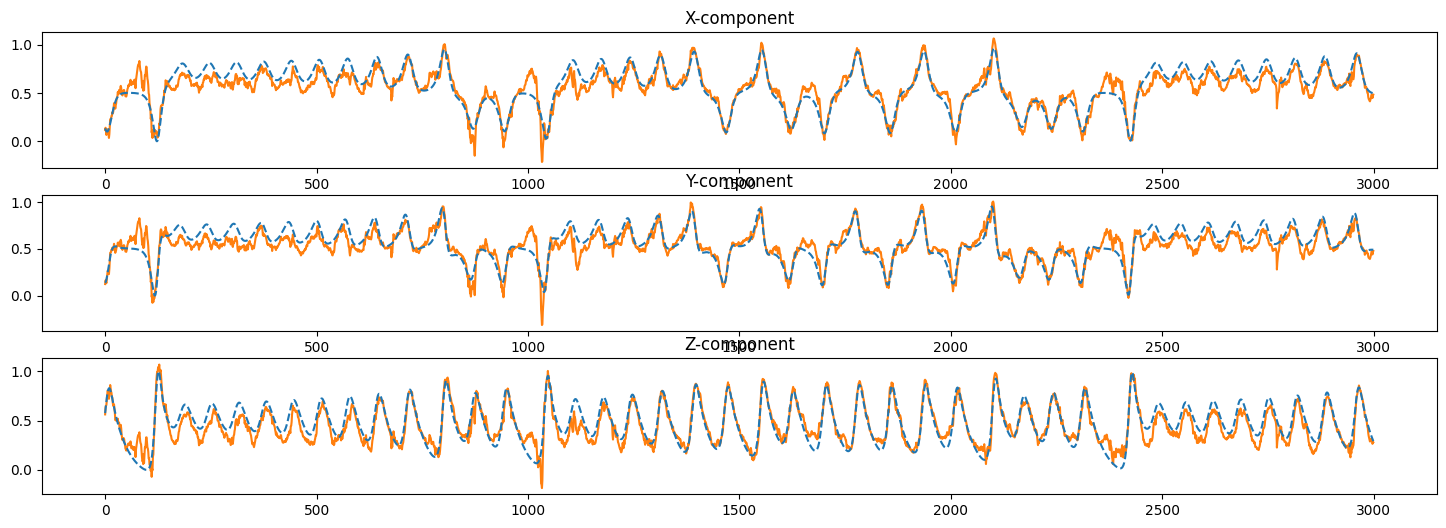

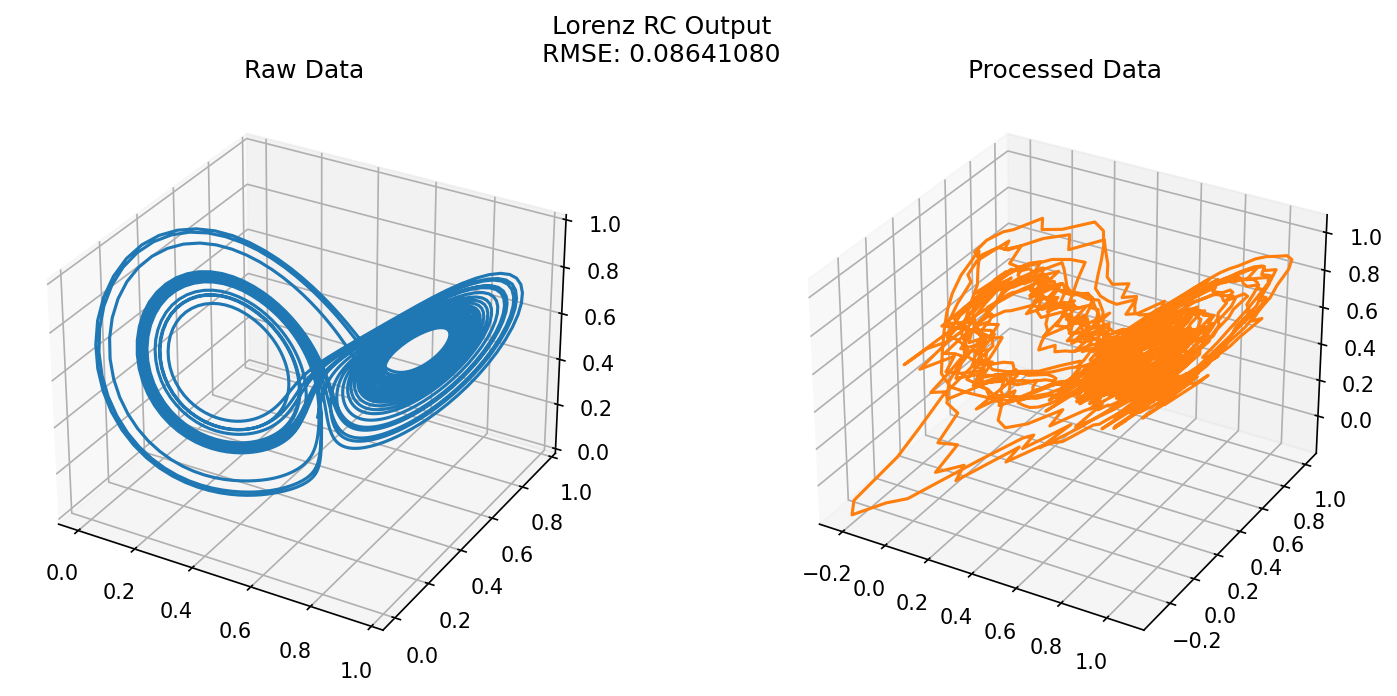

In [12]:
print(f'RMSE of output: {np.sqrt(np.mean((output - lorenz_test_target)**2))}')
show(output, lorenz_test_target, title="Lorenz RC Output")

### 迁移学习

In [13]:
new_lorenz_data = norm01(lorenz(12000, h=0.01, x0=[0.1, 0.2, 0.3])[2000:,:])
noisy_new_lorenz_data = add_noise(new_lorenz_data, noise_type="gaussian", noise_level=0.8)

In [14]:
new_lorenz_test_input = noisy_new_lorenz_data
new_lorenz_test_target = new_lorenz_data

In [15]:
states = lorenz_res.run(new_lorenz_test_input)
output = lorenz_readout.run(states)

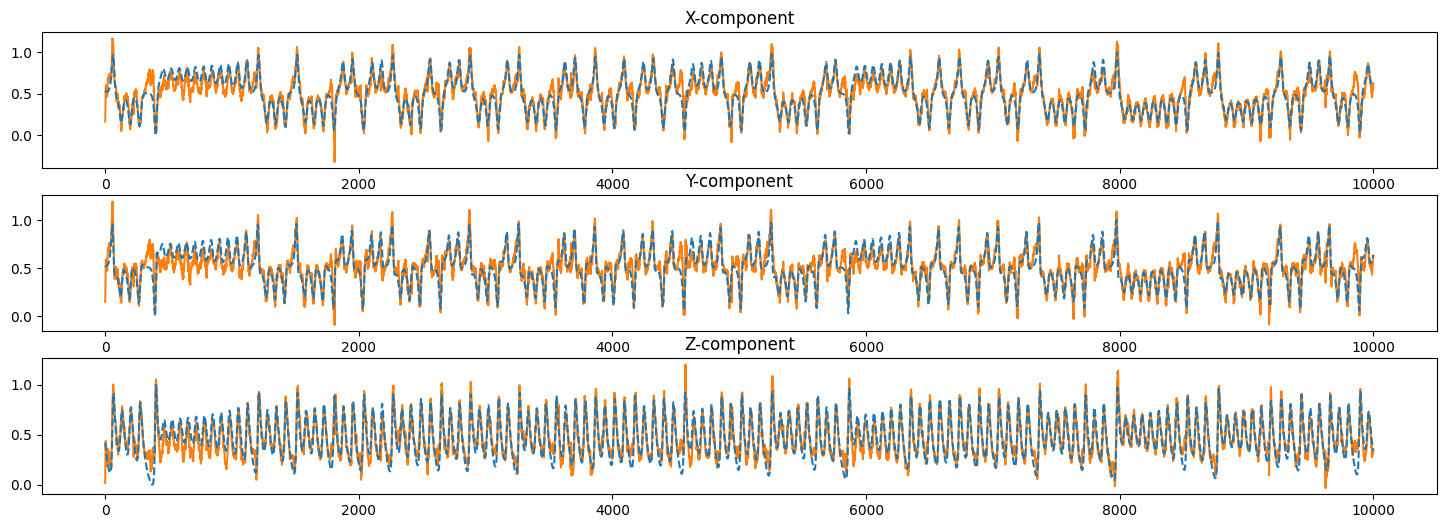

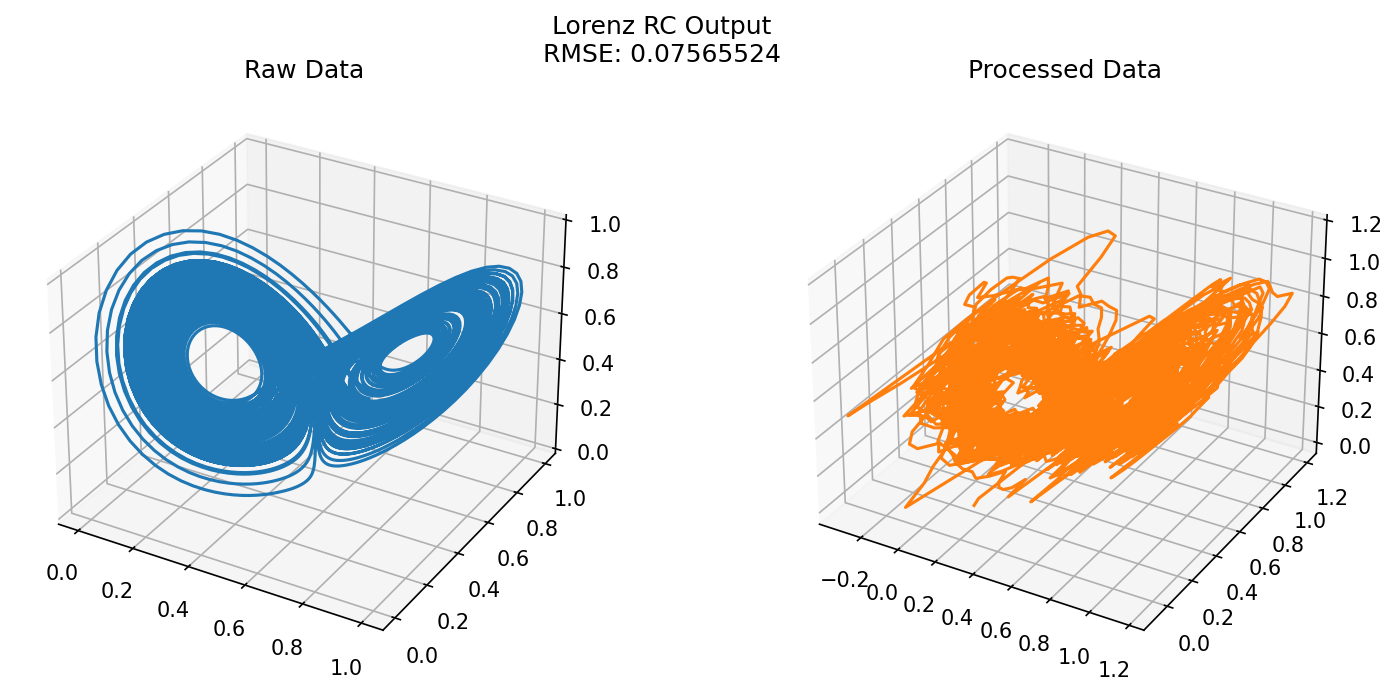

In [16]:
show(output, new_lorenz_test_target, title="Lorenz RC Output")

### Rossler Test Case

In [17]:
rossler_train_input = noisy_rossler_data[:7000]
rossler_train_target = rossler_data[:7000]

In [18]:
rossler_input = rpn.Input()
rossler_res = rpn.Reservoir(units=1000, lr=0.5, sr=0.9, activation='tanh', equation='external')
rossler_readout = rpn.Ridge(ridge=5e-3)

In [19]:
states = rossler_res.run(rossler_train_input)
rossler_readout.fit(states, rossler_train_target)
output = rossler_readout.run(states)

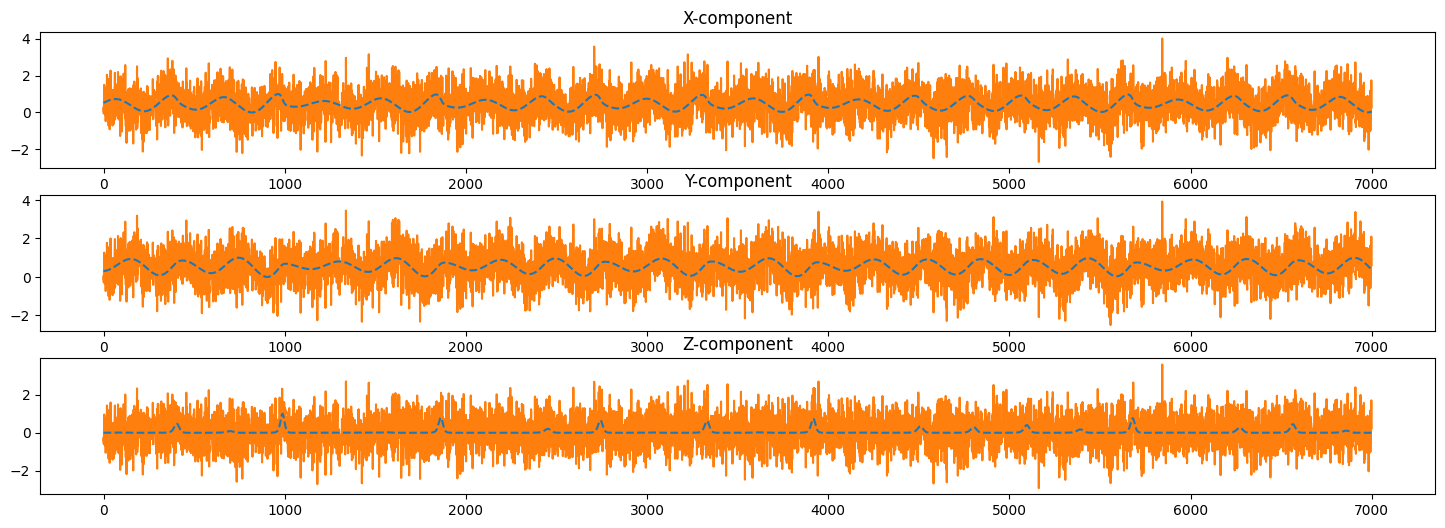

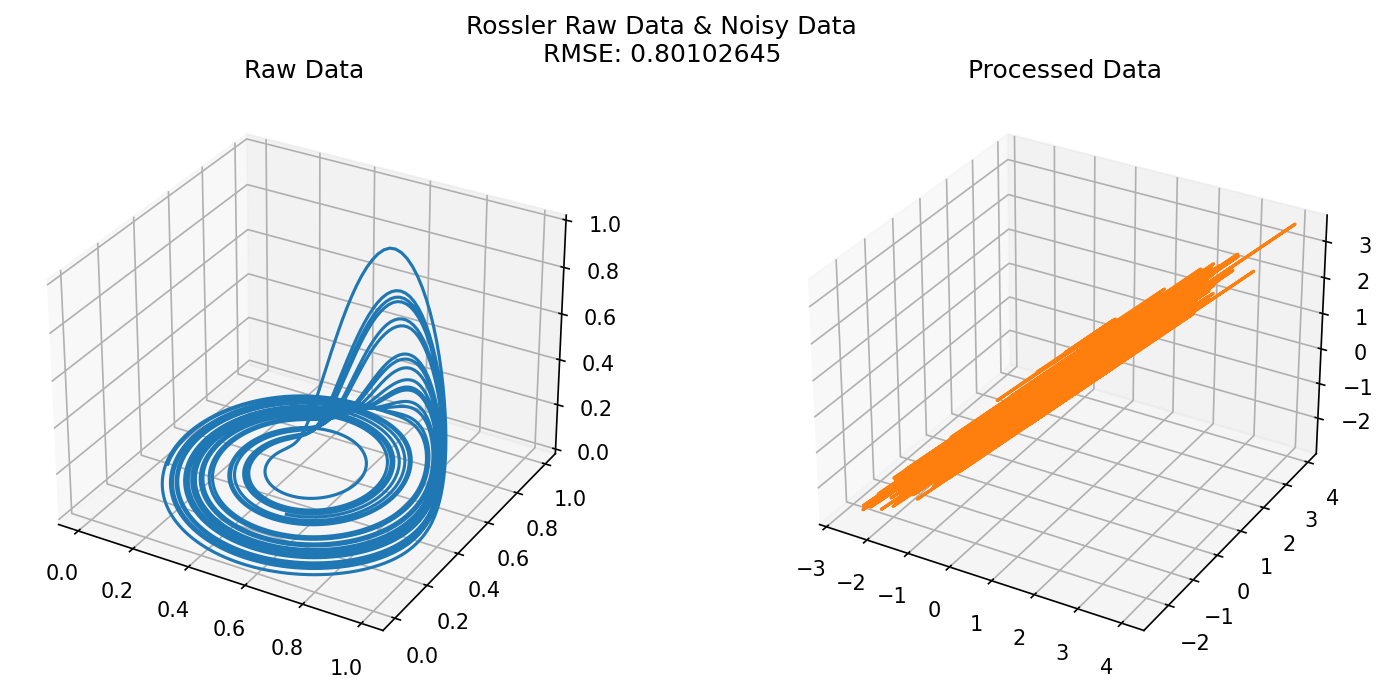

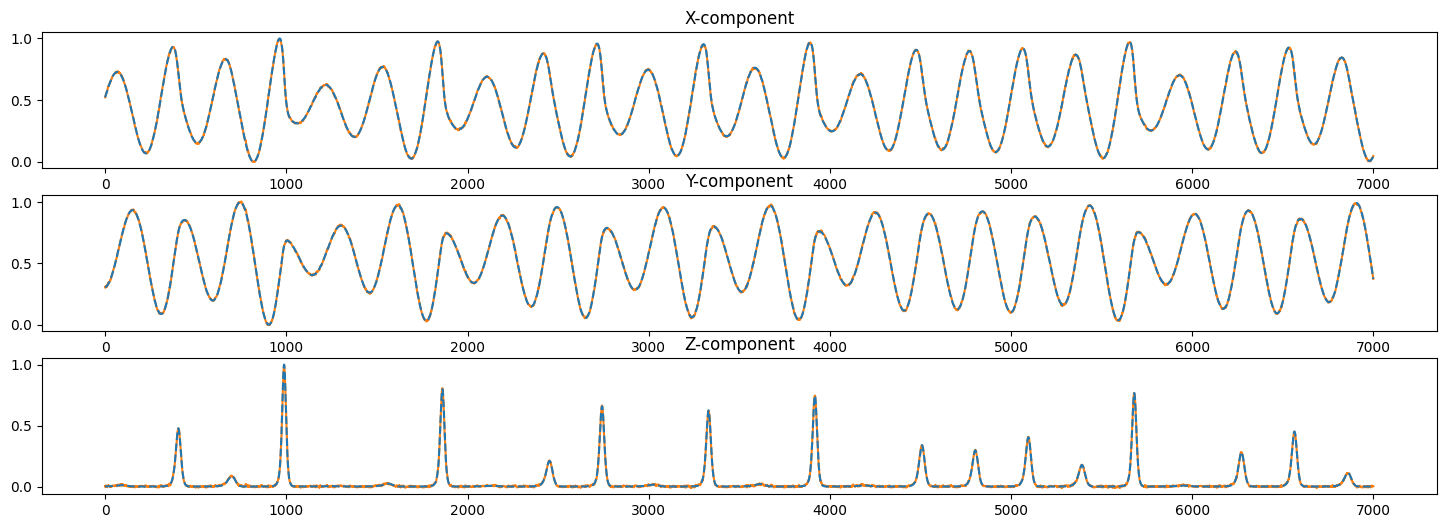

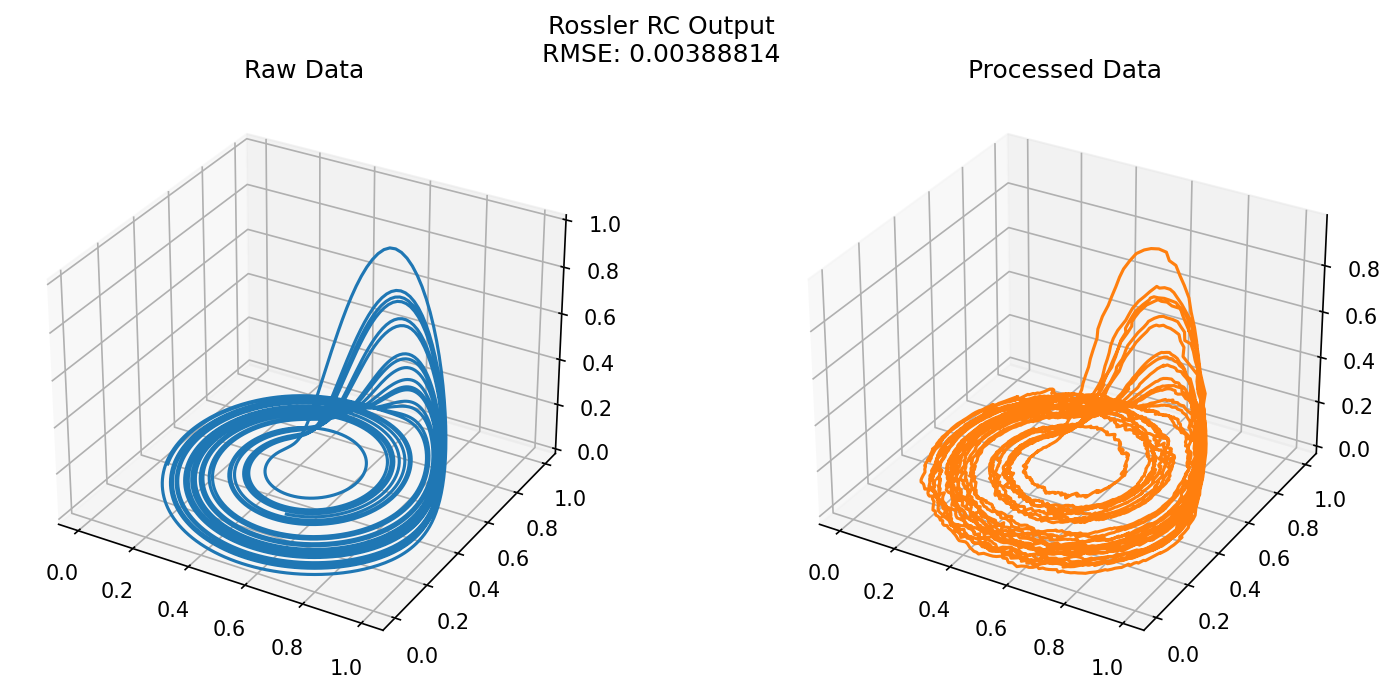

In [20]:
show(rossler_train_input, rossler_train_target, title="Rossler Raw Data & Noisy Data")
show(output, rossler_train_target, title="Rossler RC Output")

In [21]:
rossler_test_input = noisy_rossler_data[7000:]
rossler_test_target = rossler_data[7000:]

In [22]:
states = rossler_res.run(rossler_test_input)
output = rossler_readout.run(states)

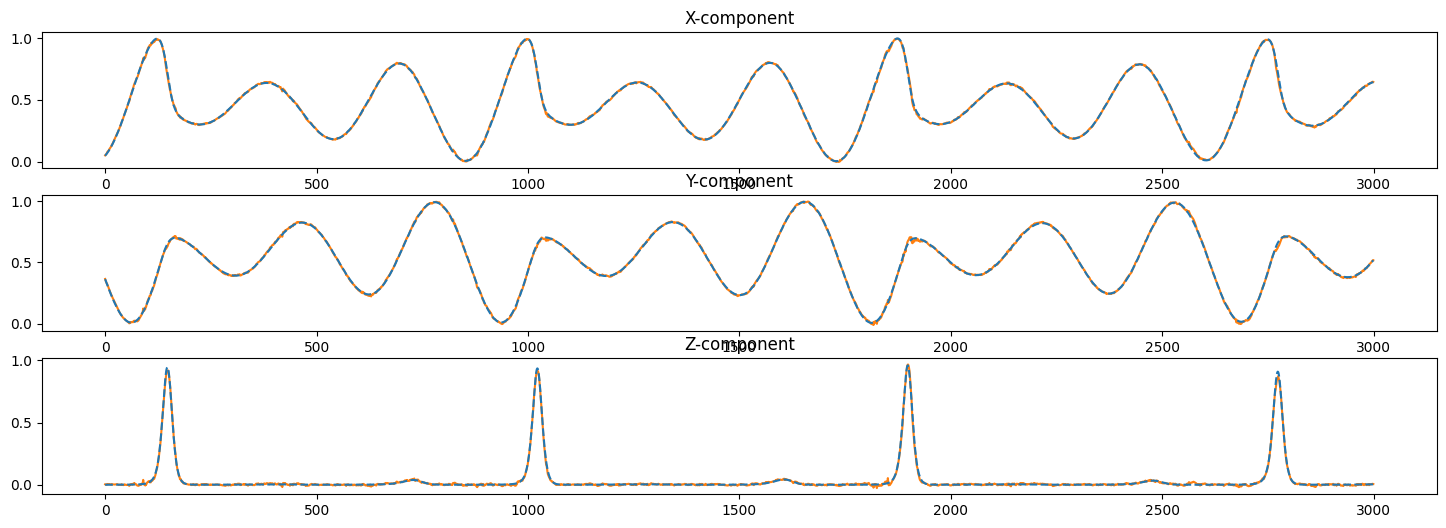

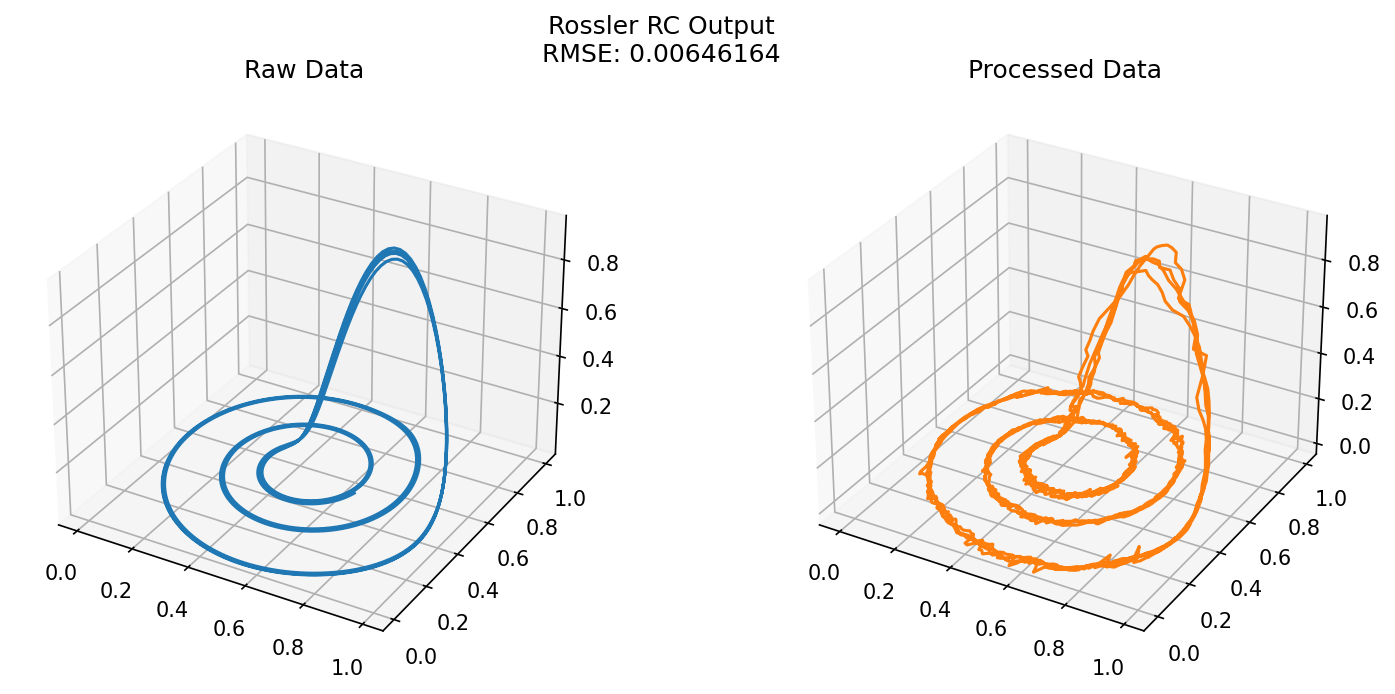

In [23]:
show(output, rossler_test_target, title="Rossler RC Output")

In [24]:
new_rossler_data = norm01(rossler(12000, h=0.02, x0=[0.1, 0.2, 0.3])[2000:,:])
noisy_new_rossler_data = add_noise(new_rossler_data, noise_type="gaussian", noise_level=0.8)

In [25]:
new_rossler_test_input = noisy_new_rossler_data
new_rossler_test_target = new_rossler_data

In [26]:
states = rossler_res.run(new_rossler_test_input)
output = rossler_readout.run(states)

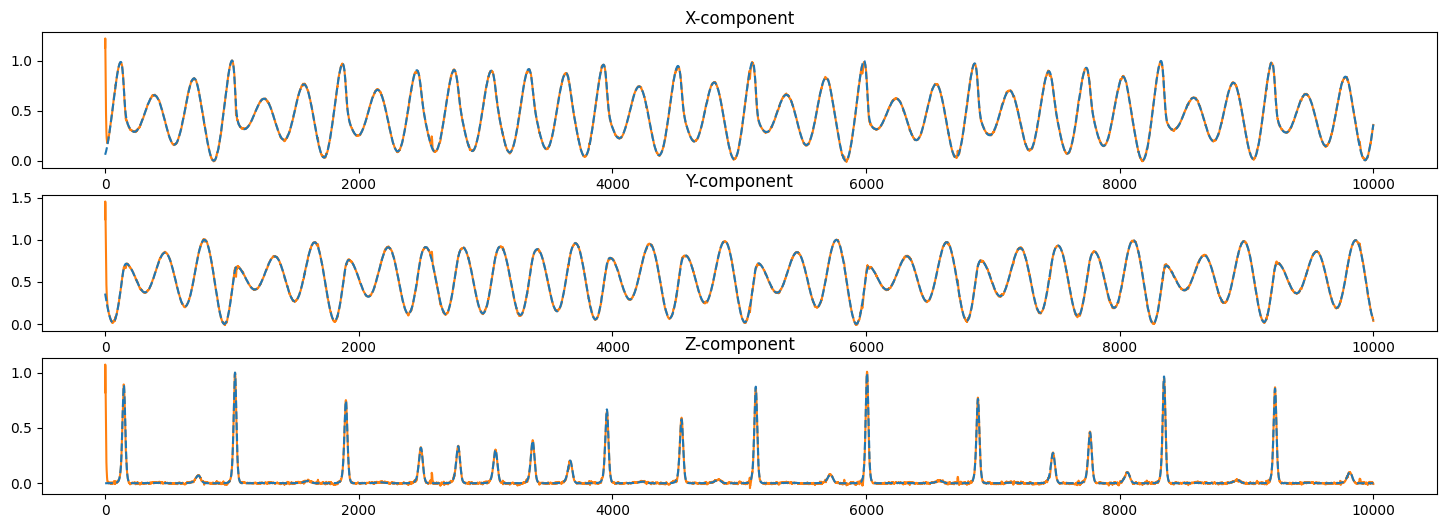

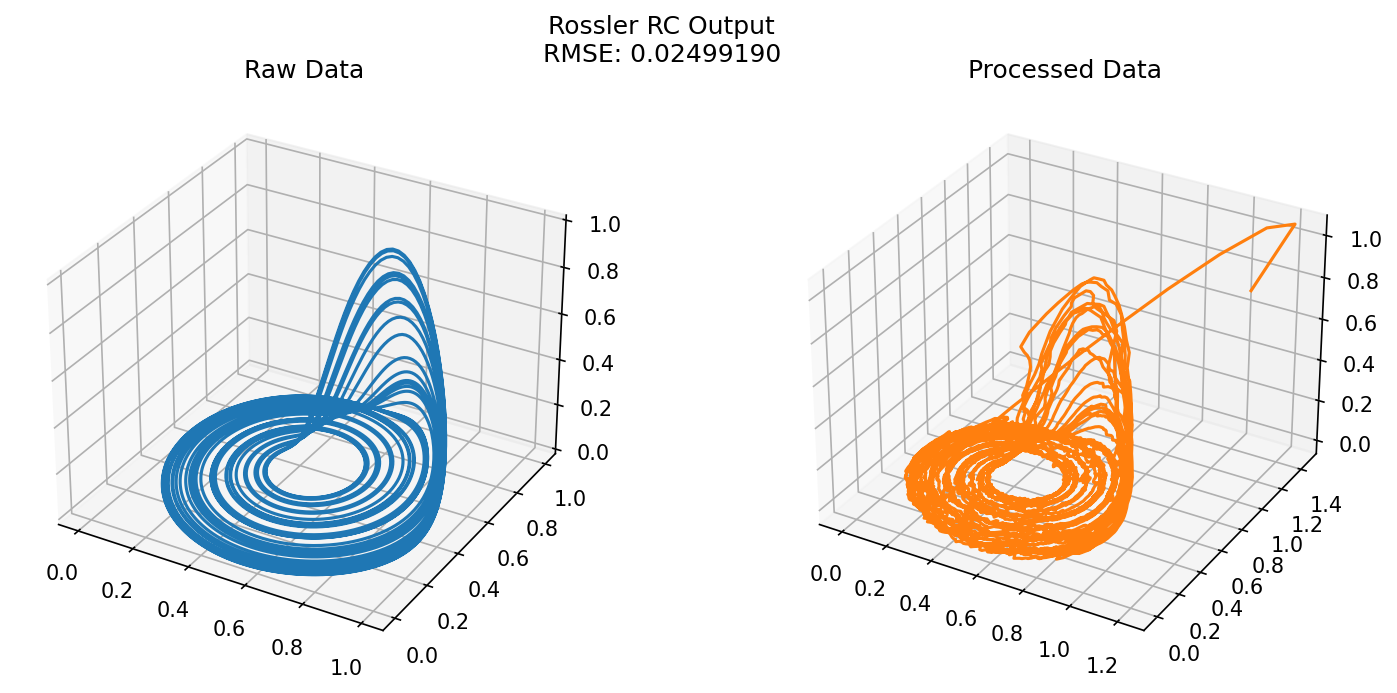

In [27]:
show(output, new_rossler_test_target, title="Rossler RC Output")

### Double-scroll test case

In [28]:
doublescroll_train_input = noisy_doublescroll_data[:7000]
doublescroll_train_target = doublescroll_data[:7000]

In [29]:
doublescroll_input = rpn.Input()
doublescroll_res = rpn.Reservoir(units=1000, lr=0.5, sr=0.9, activation='tanh', equation='external')
doublescroll_readout = rpn.Ridge(ridge=5e-3)

In [30]:
states = doublescroll_res.run(doublescroll_train_input)
doublescroll_readout.fit(states, doublescroll_train_target)
output = doublescroll_readout.run(states)

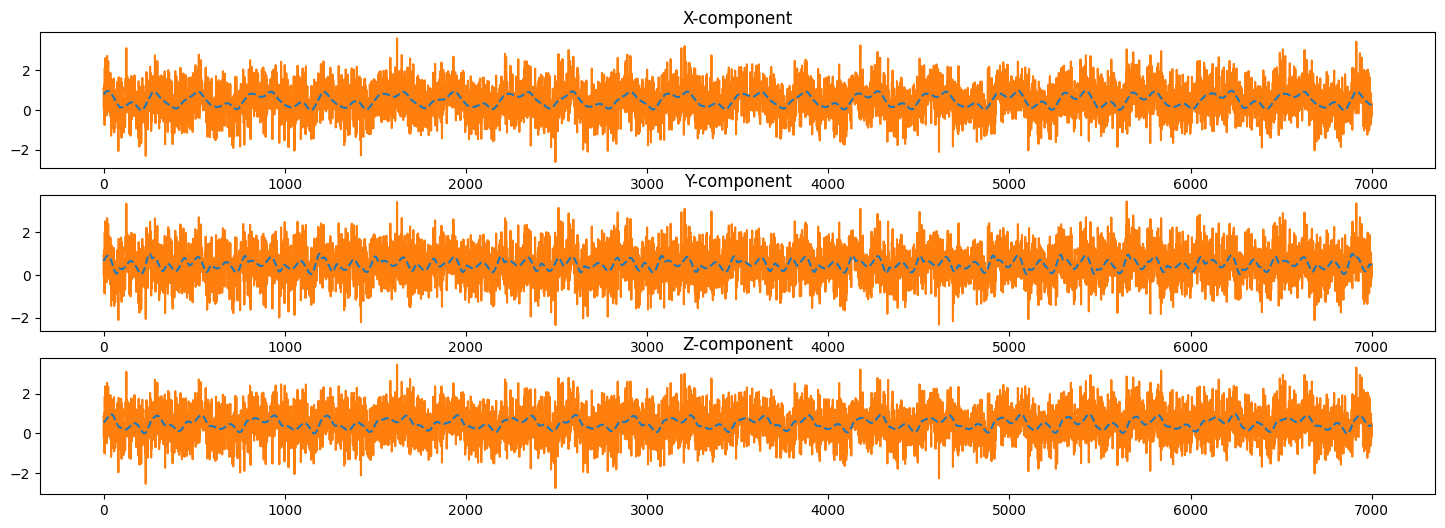

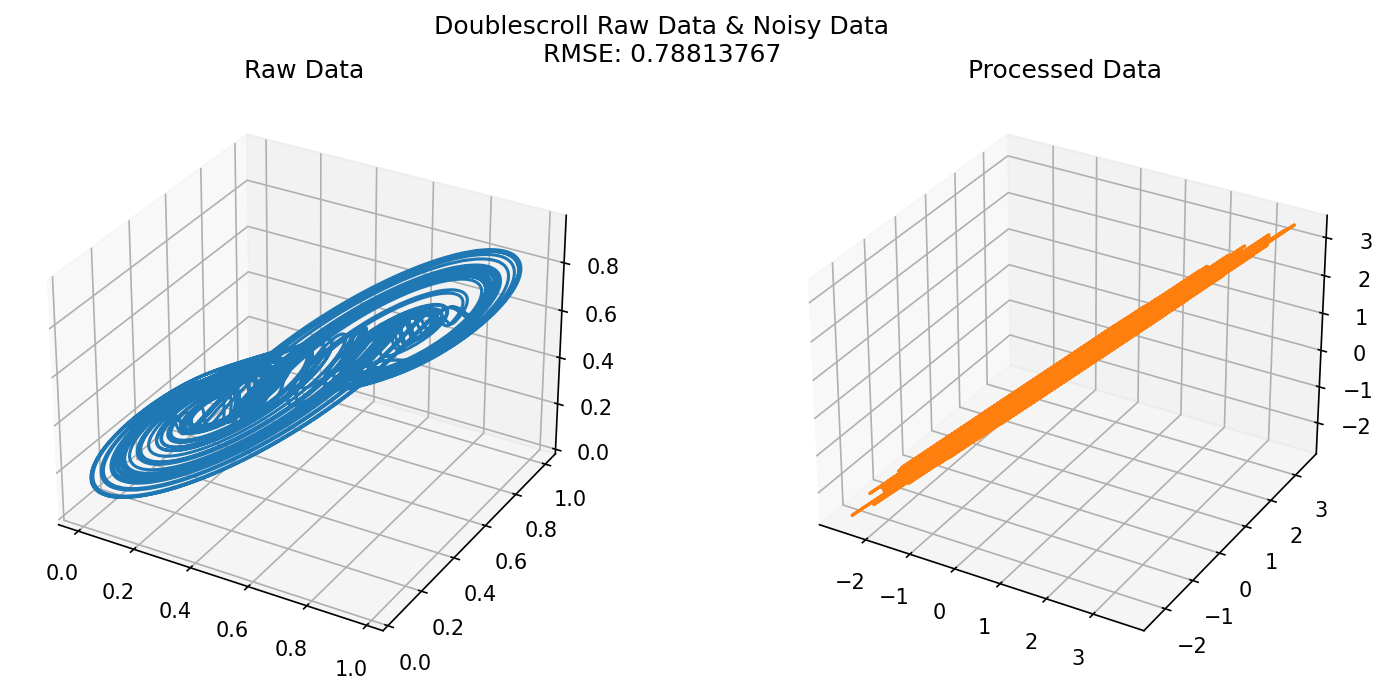

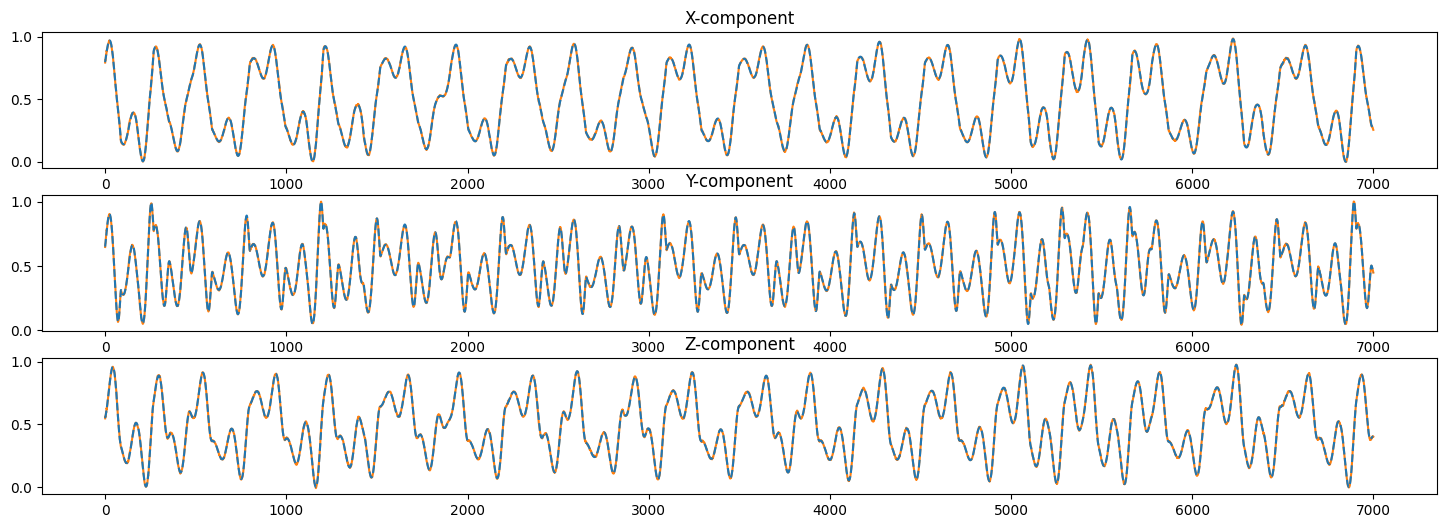

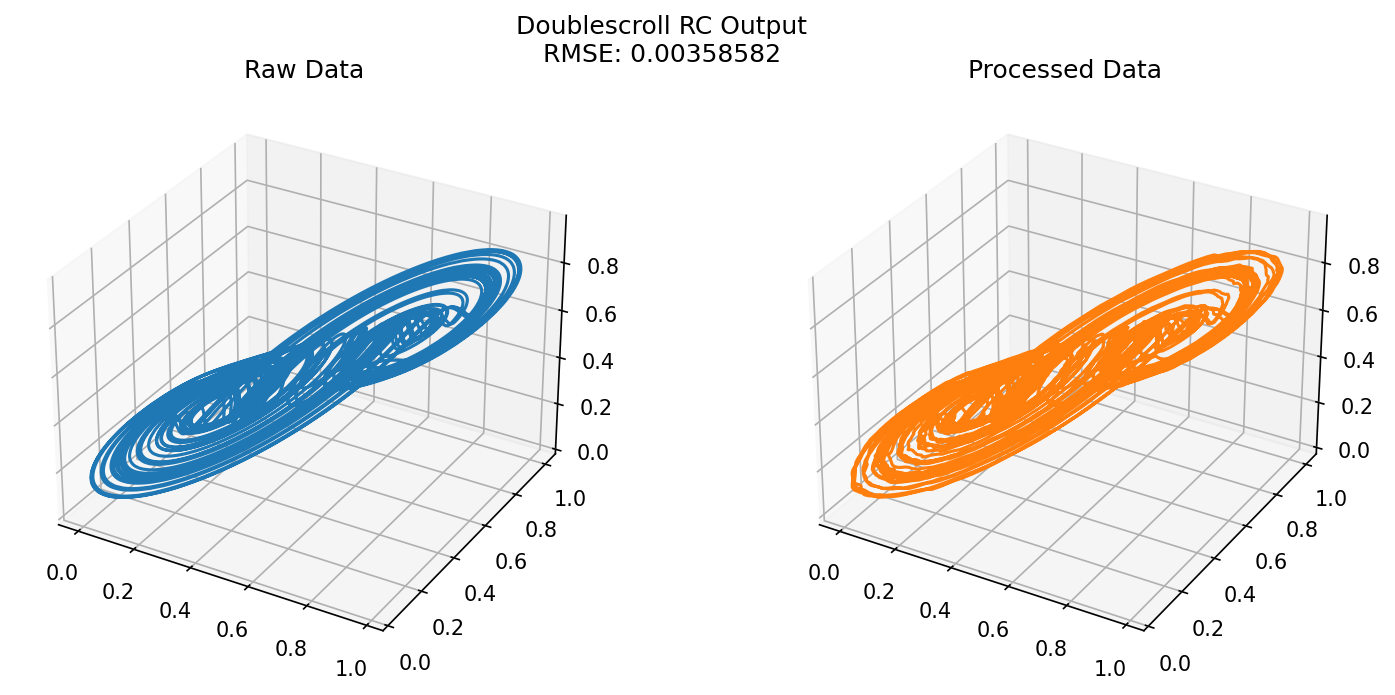

In [31]:
show(doublescroll_train_input, doublescroll_train_target, title="Doublescroll Raw Data & Noisy Data")
show(output, doublescroll_train_target, title="Doublescroll RC Output")

In [32]:
doublescroll_test_input = noisy_doublescroll_data[7000:]
doublescroll_test_target = doublescroll_data[7000:]

In [33]:
states = doublescroll_res.run(doublescroll_test_input)
output = doublescroll_readout.run(states)

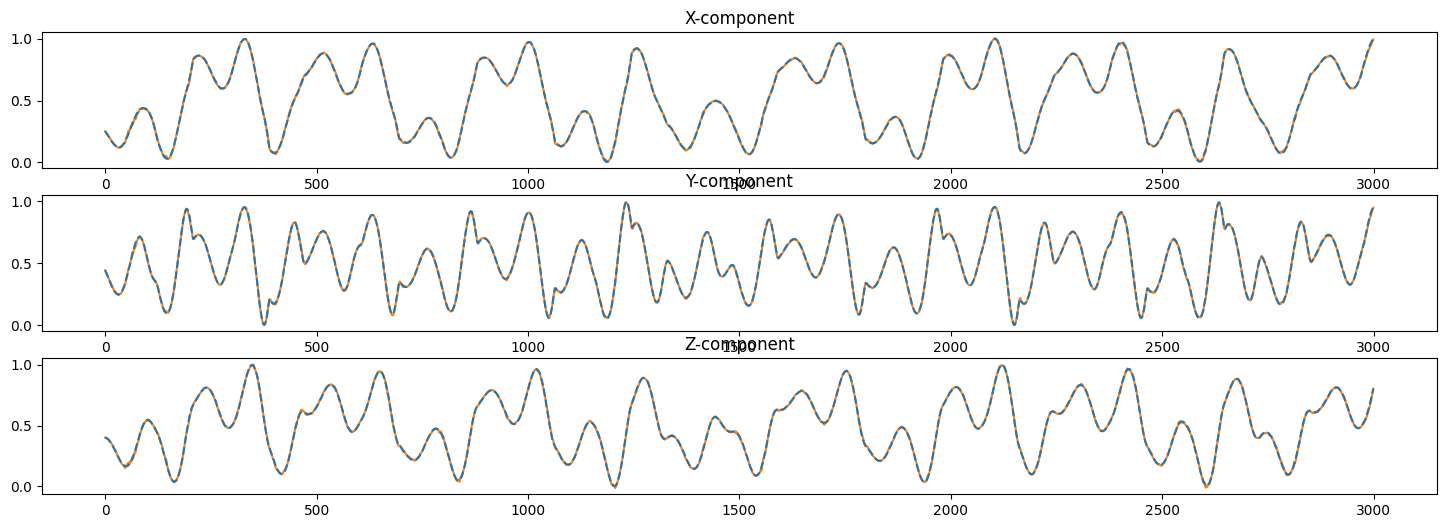

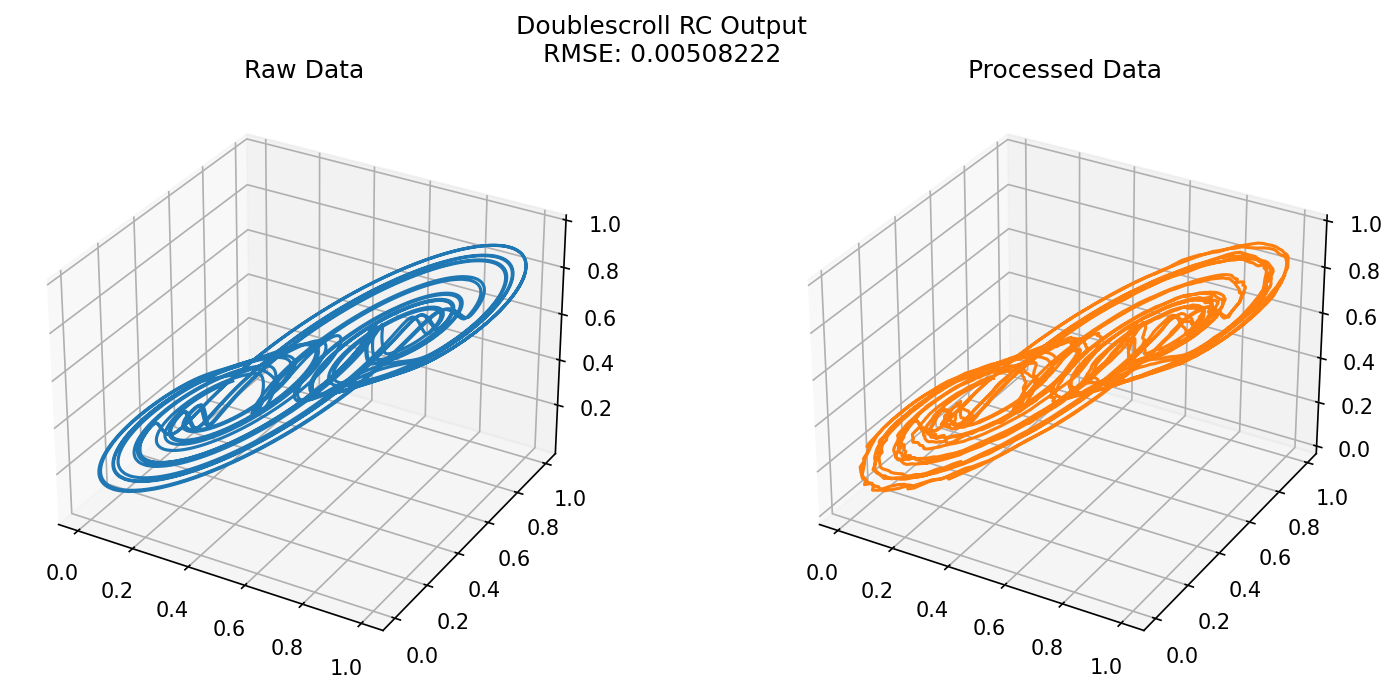

In [34]:
show(output, doublescroll_test_target, title="Doublescroll RC Output")

In [35]:
new_doublescroll_data = norm01(doublescroll(12000, h=0.1, x0=[0.1, 0.2, 0.3])[2000:,:])
noisy_new_doublescroll_data = add_noise(new_doublescroll_data, noise_type="gaussian", noise_level=0.8)

In [36]:
new_doublescroll_test_input = noisy_new_doublescroll_data
new_doublescroll_test_target = new_doublescroll_data

In [37]:
states = doublescroll_res.run(new_doublescroll_test_input)
output = doublescroll_readout.run(states)

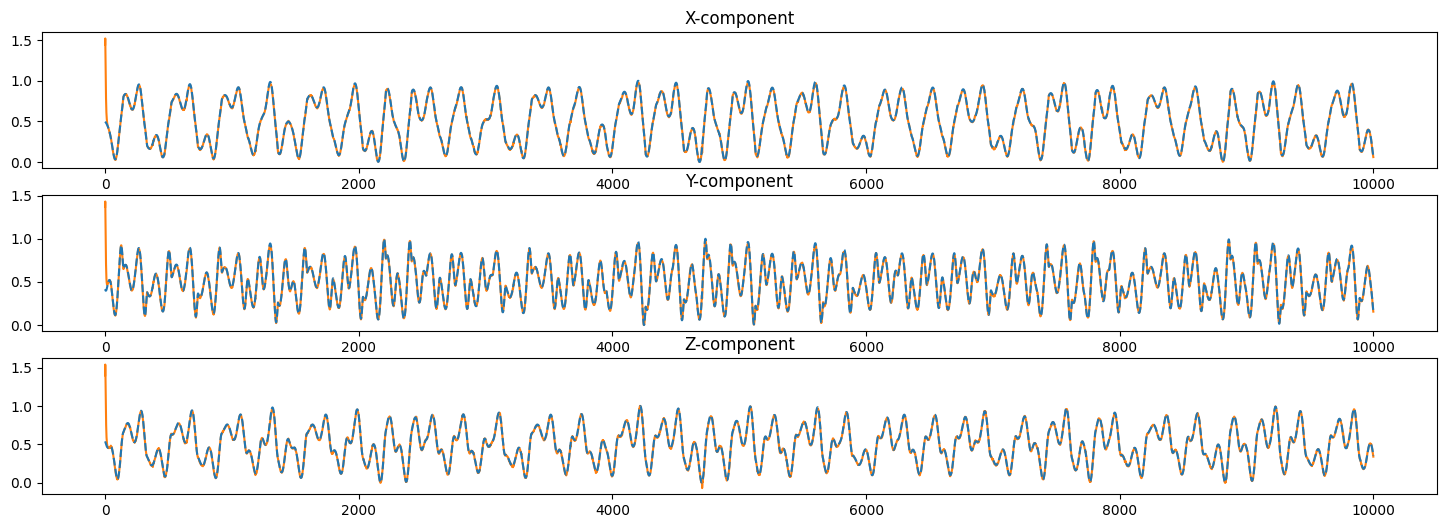

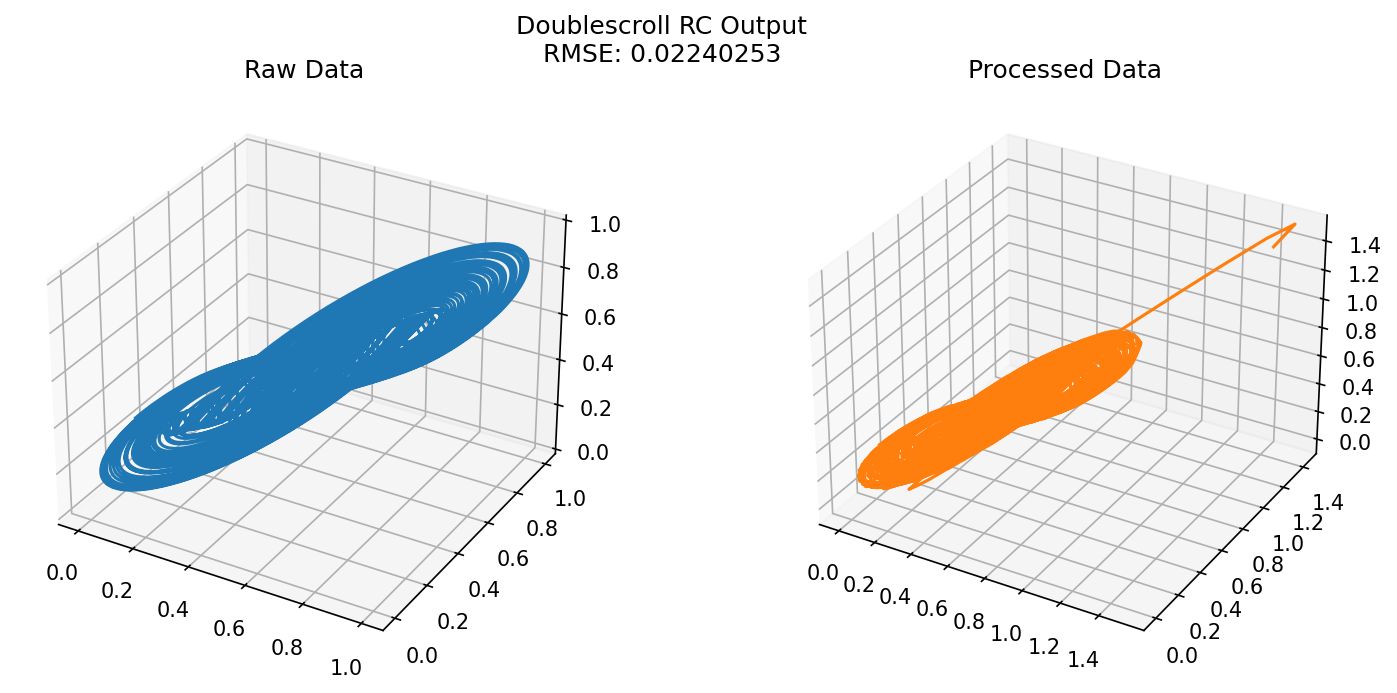

In [38]:
show(output, new_doublescroll_test_target, title="Doublescroll RC Output")